In [5]:
import torch

# dataset
from torchvision import datasets, transforms

# network architecture
from torch import nn
import torch.nn.functional as F

# network training
from torch import optim

## Load Dataset
Learn load dataset using Pytorch DataLoader

In [16]:
# define transform to normalize features
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# download dataset and load using DataLoader
trainset = datasets.FashionMNIST(
    'data',
    download=True,
    train=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

testset = datasets.FashionMNIST(
    'data',
    download=True,
    train=False, 
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=True
)

## Build model architecture

In [4]:
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        # flatten input layer
        self.flatten = nn.Flatten()

        # stack layers using sequential
        self.stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.stack(x)
        return x

## Train and Test Network

In [25]:
# define classifier, optimizer, and loss function
model = Network().to('cuda')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

EPOCH = 30

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
for e in range(EPOCH):
    
    running_loss = 0
    running_accuracy = 0

    for images, labels in trainloader:

        # move torch to cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # make sure optimizer back to 0 every loops
        optimizer.zero_grad()

        # forward step
        ## resulting log probabilities since our last layer
        ## is Log Softmax layer
        log_ps = model(images)

        # calculating loss
        loss = criterion(log_ps, labels)
        running_loss += loss.item()

        # calculating train accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        running_accuracy += torch.mean(equals.type(torch.FloatTensor))

        # backpropagation
        loss.backward()

        # update weights
        optimizer.step()    

    else:
        running_test_loss = 0
        running_test_acc = 0

        with torch.no_grad():
            for images, labels in testloader:
                
                # move data to cuda
                images, labels = images.to('cuda'), labels.to('cuda')

                # forward pass
                log_ps = model(images)

                # calculate loss
                loss = criterion(log_ps, labels)
                running_test_loss += loss.item()

                # calculate accuracy            
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                running_test_acc += torch.mean(equals.type(torch.FloatTensor))
    
    # add train accuracy and loss for each epoch
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    train_acc = running_accuracy / len(trainloader)
    train_accuracies.append(train_acc)

    # add test accuracy and loss for each epoch
    test_loss = running_test_loss / len(testloader)
    test_losses.append(test_loss)

    test_acc = running_test_acc / len(testloader)
    test_accuracies.append(test_acc)

    # print epoch detail
    print(f'Epoch: {e+1}/{EPOCH}')
    print(f'Train Loss: {train_loss}')
    print(f'Train Acc: {train_acc}')
    print('----------')
    print(f'Test Loss: {test_loss}')
    print(f'Test Acc: {test_acc}')
    print('==========')

Epoch: 1/30
Train Loss: 0.5386981469259333
Train Acc: 0.8023720979690552
----------
Test Loss: 0.47066555803368804
Test Acc: 0.8293192386627197
Epoch: 2/30
Train Loss: 0.40147268430574107
Train Acc: 0.8552272319793701
----------
Test Loss: 0.4507655840200983
Test Acc: 0.8348925113677979
Epoch: 3/30
Train Loss: 0.36496022461987
Train Acc: 0.8689365386962891
----------
Test Loss: 0.4127044919759605
Test Acc: 0.8550955653190613
Epoch: 4/30
Train Loss: 0.3392992345000635
Train Acc: 0.8759161829948425
----------
Test Loss: 0.3869450210006374
Test Acc: 0.8693272471427917
Epoch: 5/30
Train Loss: 0.32554435575091
Train Acc: 0.8813466429710388
----------
Test Loss: 0.37050228694062326
Test Acc: 0.8718152642250061
Epoch: 6/30
Train Loss: 0.30645371631169116
Train Acc: 0.8883428573608398
----------
Test Loss: 0.3619048615359956
Test Acc: 0.871715784072876
Epoch: 7/30
Train Loss: 0.2966590254212112
Train Acc: 0.8918243646621704
----------
Test Loss: 0.37193576630893027
Test Acc: 0.8735071420669556

## Plot Result

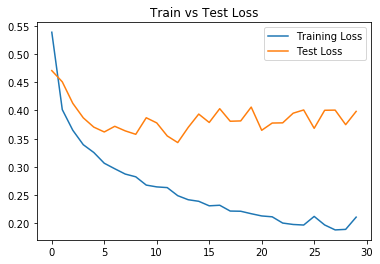

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()

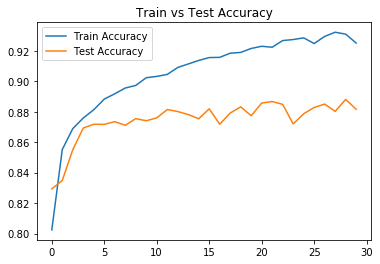

In [27]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.show()

## Saving Model

In [ ]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoints/model-checkpoint.pth')

## Load Model

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [ ]:
model = load_checkpoint('checkpoint.pth')
print(model)